###Task 2  and Task 3

Name: Sai Srujan<br>

This notebook covers Task 2 and Task 3 -  Review Sentiment Classification and  Review Helpfulness Classification.<br>
In these tasks we assign a class label in each of the tasks to all the reviews accordingly and build classifiers to distinguish the class labels and classify the new unseen reviews. 

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

Load the reviews data into a dataframe that was scraped and saved in the Product_Reviews csv from Task1

In [2]:
product_reviews = pd.read_csv("./Product_Reviews.csv")

In [3]:
# Displaying the dataframe to check if the data is loaded properly
product_reviews.head(5)

,rating,title,review_body,helpful_user,total_user
0,5,This filter works PERFECT!,"Seriously, I love my Keurig. I love the conven...",472,477
1,4,This stuff is great for muffins,There's a recipe on the back of the package fo...,17,17
2,1,Curiously awful,Cola is by far my favorite drink. My wife and ...,1,14
3,1,Rancid!,"I love chia, but I have gotten two different p...",23,26
4,1,They taste like boogers,"If you don't like the sound of a salty, vinega...",4,19


Create a set of documents from all the reviews by concatenating the review title and review body of each review.<br>
This document corpus would be used to train and test the various classfiers.

In [4]:
product_reviews['docs'] = product_reviews['title'] + '. ' + product_reviews['review_body']

#### Task 2 -  Review Sentiment Classification

A review is assigned a class label 'positive' if the rating of a particular review is 4 or 5. If the rating of a review is between 1 to 3, then a class label 'negative' will be assigned to it.

In [5]:
""" Creating a column sentiment_label in the product_reviews dataframe and assigning the class labels based on the rating
 given to a review"""
product_reviews["sentiment_label"] = np.where(product_reviews["rating"]>3,"postive","negative")

In [6]:
# Displaying the top ten rows of the dataframe to check if the class labels are assigned properly
product_reviews[['docs', 'rating', 'sentiment_label']].head(10)

,docs,rating,sentiment_label
0,"This filter works PERFECT!. Seriously, I love ...",5,postive
1,This stuff is great for muffins. There's a rec...,4,postive
2,Curiously awful. Cola is by far my favorite dr...,1,negative
3,"Rancid!. I love chia, but I have gotten two di...",1,negative
4,They taste like boogers. If you don't like the...,1,negative
5,"Tasty, plenty of seaweed.. This is good, plain...",5,postive
6,"I wouldn't cook with it, but it may have medic...",3,negative
7,Orange Blossom Heaven. If you ever want a awes...,5,postive
8,"Omaha cheesecake sampler/ Teresa, ny. I purcha...",5,postive
9,Tasty and unique. After trying Artisana's Caca...,4,postive


To build a classifier for text classification, the documents have to be pre processed to be converted into a suitable numeric representation that can be used by the classifiers to train and test. The pre processing steps inculde tokenization, conversion of all the words into lowercase to maintain consistency, removing stop words, stemming or lemmatisation where the words are trimmed to the root form, filtering the infrequent terms, vectorization and tf-idf weighting. After the pre processing is done for each document a sparse matrix is produced that is in numeric format which can be used by the classifiers for the classification.  

Building the analyzer of the CountVectorizer to incorporate the PorterStemmer to include it as a part of the text pre processing. The PorterStemmer is used for stemming the words to obtain the root form of the words.<br>
To use the stemmer nltk library must be installed.<br>
- pip install nltk (or)
- conda install nltk


In [7]:
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Build the analyzer of the Countvectorizer
analyzer = CountVectorizer().build_analyzer()

# This function will be called by the analyzer for every document in the corpus to perform the stemming operation.
def stemmer(doc):
    return (porter_stemmer.stem(w) for w in analyzer(doc))

A pipeline is setup with all the pre processing steps and the classifier model using the countVectorizer, TfidfTransformer and the linear SVM classifier

In [8]:
"""
CountVectorizer has an analyzer as one of it's parameter which is used to include the stemming as a part of its' processing.
The stop_words parameter ensures that it removes all the stop words such as an,the,has,him,etc. which is defined in the 
list of stop words(removing stop words).
The min_df parameter set to 5 ensures that all the terms which appear in less than 5 documents will be 
ignored.(Filtering the infrequent terms).
The CountVectorizer by default converts all the words into lowercase and filters the terms with length < 1.
So, with the CountVectorizer, we set up all the pre processing steps required to convert into document term matrix.
We, then use the TfidfTransformer, to perform the tf idf weighting to all the terms and make the document term matrix
more useful by penalising the most common terms and assigning weights accordingly to the more important terms.
"""
SVMPipelineStem = Pipeline([
    ('vec', CountVectorizer(analyzer = stemmer, stop_words="english", min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge'))
])

A similar pipeline is set up excluding the stemming operation, to compare the performance of the classifier 

In [9]:
SVMPipeline = Pipeline([
    ('vec', CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge'))
])

In [10]:
# Split the dataset into training and test sets along with the target labels
data_train_t2, data_test_t2, target_train_t2, target_test_t2 = train_test_split(product_reviews['docs'], product_reviews["sentiment_label"], test_size=1/2)

Fit both the pipelines with the train data and use the test data for the predictions using which the accuracy of the classifier can be determined

In [11]:
# Pipeline with stemming operation
SVMPipelineStem.fit(data_train_t2, target_train_t2)
predicted = SVMPipelineStem.predict(data_test_t2)
print("Classification accuracy = %.2f" % (accuracy_score(target_test_t2, predicted)*100))

Classification accuracy = 86.07


In [12]:
# Pipeline without stemming operation
SVMPipeline.fit(data_train_t2, target_train_t2)
predicted = SVMPipeline.predict(data_test_t2)
print("Classification accuracy = %.2f" % (accuracy_score(target_test_t2, predicted)*100))

Classification accuracy = 85.05


It can be observed from the above two results, that there is only a slight improvement in the accuracy of the classifier when the stemming operation is performed as the words like 'brand', 'branded' and 'branding' would be reduced to the root form that is 'brand' and then number of similar words used for training the classifier would decrease which would help the classifier to classify the documents more accurately.<br>
But when stemming is performed, some of the words would be stemmed that would not make sense and also it can be observed that when we fit and predict the data, it takes longer time when compared to the pipeline without the stemming and it would take even longer time when cross validation is performed. Since, there is only a slight increment in the accuracy and it takes a very long time to pre process, we consider the pipeline without the stemmer and perform cross validation to evaluate the accuracy of the classifier. 

Considering the pipeline without stemming and evaluating the classifier with the hold out strategy where the training and test data is split. The training data only is provided to fit and train the classifier. The test data without the labels is provided to the classifier to evaluate the accuracy of the classifier based on how well it classifies the unseen samples.

Classification accuracy = 85.05


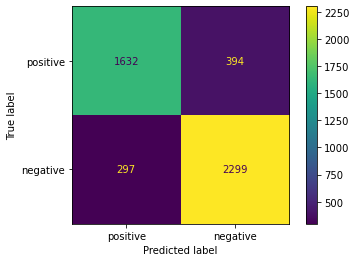

In [13]:
predicted = SVMPipeline.predict(data_test_t2)
print("Classification accuracy = %.2f" % (accuracy_score(target_test_t2, predicted)*100))
# calculate the confusion matrix
cm = confusion_matrix(target_test_t2, predicted)
# displaying the confusion matrix
target_categories = ["positive","negative"]
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

It can be observed from the confusion matrix that the false positive rate is more than the false negative rate. So, the number of positive reviews getting predicted as negative is slighlty more than the negative reviews getting predicted as positive. The accuracy of the classifier is around 85% which illustrates that the classifier is able to classify most of the unseen reviews correctly.

Hold out strategy is a lucky split of data into train and test data. So, the data is randomly split into test and train data and sometimes the test data would have majority of the difficult reviews to classify which would reduce the accuracy of the classifier. Sometimes, there might be majority of easy reviews to classify which would improve the accuracy of the classifier. And also, the train data would not have a great variety of reviews to train the classifier which would reduce the accuracy and vice-versa.<br>
In order to ensure we evaluate the classifier properly, we use the cross validation strategy. In the cross validation strategy of 10 folds, the data is split into 10 folds. One fold is used to test the classifier where the rest of the folds are used to train the classifier in each experiment. So, the experiment will be repeated for 10 times with each experiment using a different fold for testing. 
The accuracy of the classifier is then taken as the average of the accuracies obtained from all the experiments. So this ensures that the accuracy of the classifier is more reliable.

In [14]:
# Running the Linear SVM Classifier pipeline with 10 fold cross validation
acc_arr = cross_val_score(SVMPipeline, product_reviews['docs'], product_reviews["sentiment_label"], cv=10, n_jobs = -1)
print("Linear Support vector Machine(10 fold cross validation) accuracy: %.2f" % ((sum(acc_arr)/len(acc_arr))*100))

Linear Support vector Machine(10 fold cross validation) accuracy: 88.63


We set up a similar pipeline with all the similar pre processing steps with a KNN classifier with 3 nearest neighbors

In [15]:
KNNPipeline = Pipeline([
    ('vec', CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

We fit the KNN pipeline with the same train data, so we can compare the accuracy of the classifier when same data is used for training and testing the classifier

In [16]:
KNNPipeline.fit(data_train_t2, target_train_t2)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

Similarly, like we did for the previous classifier we train and test the pipeline using the hold out strategy evaluation.

Classification accuracy = 72.44


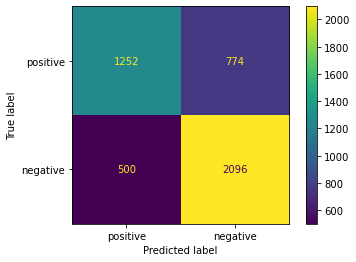

In [17]:
predicted = KNNPipeline.predict(data_test_t2)
print("Classification accuracy = %.2f" % (accuracy_score(target_test_t2, predicted)*100))
# calculate the confusion matrix
cm = confusion_matrix(target_test_t2, predicted)
# display the confusion matrix
target_categories = ["positive","negative"]
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

It can be observed from the confusion matrix that the false positive rate is slightly more than the false negative rate for the KNN classifier. So, the number of positive reviews getting predicted as negative reviews is more than the number of negative reviews getting predicted as positive. The accuracy of the classifier is around 72%.

Even this classifier pipeline is evaluated using the 10 fold cross validation strategy to obtain the average accuracy of the classifier.

In [18]:
# Running the KNN Classifier pipeline with 10 fold cross validation
acc_arr = cross_val_score(KNNPipeline, product_reviews['docs'], product_reviews["sentiment_label"], cv=10, n_jobs = -1)
print("K-Nearest Neighbors(n=3)(10 fold cross validation) accuracy: %.2f" % ((sum(acc_arr)/len(acc_arr))*100))

K-Nearest Neighbors(n=3)(10 fold cross validation) accuracy: 74.64


The SGDClassifier when the loss property is set to hinge gives linear SVM classifier. The Support Vector Machine algorithm is a supervised learning algorithm for classification. The SVM classifier defines a hyperplane from the training data to determine and separate the various categories of class labels being predicted. The hyperplane is decided based on the support vectors which is a subset of the training data.  So, the SGDClassifier implements the hyperplane similarly when the loss function is set and predicts the labels for the unseen data. The SGDClassifier works well for data which is sparse and also performs well even if the amount of data and the number of features are huge.<br>

K-Nearest Neighbors(KNN) algorithm is also a supervised machine learning classification algorithm. The KNN algorithm classifies the unseen data into various categories based on the number of nearest neighbors that are similar to the data. So, the number of nearest neighbors plays a major role in KNN algorithm. The new data will be assigned a class label which is the majority of the k nearest neighbors.( Ex: If k is 3 and 2 neighbors are positive and one neighbor is negative, then the new data will be assigned a class label positive).<br>

It can be observed from the above results that the linear Support Vector Machine(SVM) classifier has more accuracy than the K-Nearest Neighbor classifier. The linear SVM classifer has an accuracy of around 89% and the KNN classifier has an accuracy of around 75% obtained from cross validation in both the cases.<br>

The text pre processing step involves converting the textual data into a numeric representation. It is converted into a document term matrix with the tf-idf weighting for each of the terms in the document corpus. The document term matrix is a very huge sparse matrix. Since,the linear SVM classifier works well on huge sparse matrix, it can be observed that a good accuracy is obtained by the classifier for classifying the reviews as positive and negative. The number of features in the sparse matrix is also very huge as there will be a lot of terms in the document corpus and since SGDClassifier performs well on huge number of features, this classfier works well for text classification.

The KNN classifier on the other hand has comparitively less accuracy than that of the linear SVM classifier as the KNN classifier classifies the reviews based on how similar the terms in the review are compared to the new review being classified. As, the train data is a very huge sparse matrix and consists of a lot of terms, there can be neighbors which have similar terms but are of different categories which makes it difficult for the KNN classifier to classify some of the reviews accurately and hence the overall accuracy is less compared to the linear SVM classifier.

#### Task 3 -  Review Helpfulness Classification

A review is assigned a class label 'helpful' and 'unhelpful' based on a threshold value. If the number of users who have voted the review as helpful divided by the total number of users who have voted the review is greater than 0.75, the review will be assigned a class label 'helpful'. <br>
If the value calculated is less than 0.75 then the review will be assigned a class label 'unhelpful'

In [19]:
""" Creating a column help_label in the product_reviews dataframe and assigning the class labels based on the helpfulness
information of a review"""
product_reviews["help_label"] = np.where((product_reviews["helpful_user"]/product_reviews["total_user"])>0.75,"helpful","unhelpful")

In [20]:
# Displaying the top ten rows of the dataframe to check if the class labels are assigned properly
product_reviews[['docs', 'helpful_user', 'total_user', 'help_label']].head(10)

,docs,helpful_user,total_user,help_label
0,"This filter works PERFECT!. Seriously, I love ...",472,477,helpful
1,This stuff is great for muffins. There's a rec...,17,17,helpful
2,Curiously awful. Cola is by far my favorite dr...,1,14,unhelpful
3,"Rancid!. I love chia, but I have gotten two di...",23,26,helpful
4,They taste like boogers. If you don't like the...,4,19,unhelpful
5,"Tasty, plenty of seaweed.. This is good, plain...",12,12,helpful
6,"I wouldn't cook with it, but it may have medic...",3,20,unhelpful
7,Orange Blossom Heaven. If you ever want a awes...,11,12,helpful
8,"Omaha cheesecake sampler/ Teresa, ny. I purcha...",17,17,helpful
9,Tasty and unique. After trying Artisana's Caca...,17,17,helpful


A pipeline is setup with all the pre processing steps and the classifier model using the countVectorizer, TfidfTransformer and the linear SVM classifier.<br>
The text pre processing steps are similar to that of the previous task

In [21]:
SVMPipeline = Pipeline([
    ('vec', CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge'))
])

In [22]:
# Split the dataset into training and test sets along with the target labels
data_train_t3, data_test_t3, target_train_t3, target_test_t3 = train_test_split(product_reviews['docs'], product_reviews["help_label"], test_size=1/2)

Fitting the pipeline with the train data and using the test data for the predictions using which the accuracy of the classifier can be determined

In [23]:
SVMPipeline.fit(data_train_t3, target_train_t3)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()), ('clf', SGDClassifier())])

Evaluating the performance of the classifier using the hold out strategy

Classification accuracy = 79.75


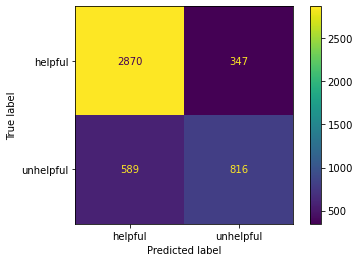

In [24]:
predicted = SVMPipeline.predict(data_test_t3)
print("Classification accuracy = %.2f" % (accuracy_score(target_test_t3, predicted)*100))
# calculate the confusion matrix
cm = confusion_matrix(target_test_t3, predicted)
# displaying the confusion matrix
target_categories = ["helpful","unhelpful"]
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

It can be observed from the confusion matrix that the false positive rate is lesser than the false negative rate. So, the number of helpful reviews getting predicted as unhelpful is lesser than the unhelpful reviews getting predicted as helpful. The accuracy of the classifier is around 80% which illustrates that the classifier is able to classify most of the unseen reviews correctly.

The classifier pipeline is evaluated using the 10 fold cross validation strategy to obtain the average accuracy of the classifier.

In [25]:
# Running the Linear SVM Classifier pipeline with 10 fold cross validation
acc_arr = cross_val_score(SVMPipeline, product_reviews['docs'], product_reviews["help_label"], cv=10, n_jobs = -1)
print("Linear Support Vector Machine (10 fold cross validation) accuracy: %.2f" % ((sum(acc_arr)/len(acc_arr))*100))

Linear Support Vector Machine (10 fold cross validation) accuracy: 82.54


We set up a similar pipeline with all the similar pre processing steps with a KNN classifier with 3 nearest neighbors

In [26]:
KNNPipeline = Pipeline([
    ('vec', CountVectorizer(stop_words="english", ngram_range=(1, 2), min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

We fit the KNN pipeline with the same train data, so we can compare the accuracy of the classifier when same data is used for training and testing the classifier

In [27]:
KNNPipeline.fit(data_train_t3, target_train_t3)

Pipeline(steps=[('vec',
                 CountVectorizer(min_df=5, ngram_range=(1, 2),
                                 stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier(n_neighbors=3))])

Evaluating the performance of the classifier using the hold out strategy

Classification accuracy = 74.30


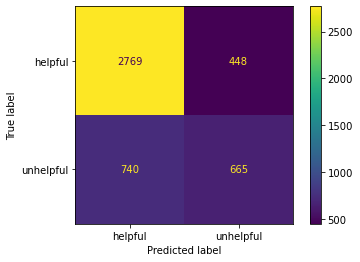

In [28]:
predicted = KNNPipeline.predict(data_test_t3)
print("Classification accuracy = %.2f" % (accuracy_score(target_test_t3, predicted)*100))
# calculate the confusion matrix
cm = confusion_matrix(target_test_t3, predicted)
# display the confusion matrix
target_categories = ["helpful","unhelpful"]
cmd = ConfusionMatrixDisplay(cm, display_labels=target_categories)
cmd.plot();

It can be observed from the confusion matrix that the false positive rate is much lesser than the false negative rate. So, the number of helpful reviews getting predicted as unhelpful is lesser than the unhelpful reviews getting predicted as helpful. The accuracy of the classifier is around 75%.

The classifier pipeline is evaluated using the 10 fold cross validation strategy to obtain the average accuracy of the classifier.

In [29]:
# Running the KNN Classifier pipeline with 10 fold cross validation
acc_arr = cross_val_score(KNNPipeline, product_reviews['docs'], product_reviews["help_label"], cv=10, n_jobs = -1)
print("K-Nearest Neighbors(n=3)(10 fold cross validation) accuracy: %.2f" % ((sum(acc_arr)/len(acc_arr))*100))

K-Nearest Neighbors(n=3)(10 fold cross validation) accuracy: 76.31


It can be observed from the above results that even in the helpfulness classification, the linear SVM classifier performs better than the KNN classifier.<br>
The linear SVM classifer has an accuracy of around 82% and the KNN classifier has an accuracy of around 76% obtained from cross validation in both the cases.<br>
Since, even this classification includes text classification and the text input data is a huge sparse matrix, as discussed before, the linear SVM classifier performs better with the huge sparse data.

Task 2 involved classification of the reviews into positive or negative reviews(sentiment classification) and Task 3 involved classification of the reviews into Helpful or Unhelpful categories.<br>
The same classifiers were used in both the tasks to enable the comparison of the performance of the classifiers in various tasks.<br>
The linear SVM classifier has an accuracy of around 89% in Task 2 and in Task 3 it has an accuracy of around 82%. The KNN classifier with 3 neighbors has an accuracy of around 75% in Task 2 and an accuracy of around 76% in Task 3.<br>
It can be seen that the accuracy of classification is slightly higher for the SVM classifier in Task 2 when compared to Task 3 and in case of KNN classifier it is almost similar in both the cases.<br>
In Task 2 as observed from the confusion matrix, the false positive rate is higher than the false negative rate but in case of Task 3, it is the other way round, where false negative rate is more than the false positive rate in both of the classifiers<br>
Task 2 classifies the reviews into positive or negative. In general if a review is positive the review would consist of some common words such as best, good, nice, enjoyed and so on. In case the review is negative it would consist of some common words such as bad, horrible, devastated and so on. So, when we train the classifier for the sentiment classification some of these words would be present in all the reviews and accordingly the labels would be set for them which allows the classifier to be trained based on that. There can be cases where some of the reviews would have words such as not nice, not bad which is  a negate condition and hence some of these reviews would not be categorised properly by the classifier as it would be a little difficult to predict.But as a whole when the new unseen reviews are used for classification if similar words are there, the classifier can predict whether they are negative or positive more easily.<br>
In case of Task 3 the reviews are classified into Helpful and Unhelpful. In this case there are no many common words to decide whether the review is helpful or unhelpful as a review which is positive might be helpful or a review which is negative also might be helpful for some users. It depends on the user who is reading the review, if the users feels it helped to make a decision then the review would be considered helpful otherwise it might be unhelpful for that user. So, there is a slight decrease in the performance of the classifiers for Task 3 when compared to Task 2.<br>
But, in general the classifiers are able to classify majority of the reviews in both the tasks with the right labels and Linear SVM performs well with good accuracy in both the tasks.

References :Scikit learn SVM classifier, SGDClassifier and KNN classifier pages.